In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import optuna
import tqdm
import joblib

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

In [2]:
train = pd.read_csv('train_dataset.csv')
test = pd.read_csv('x_test.csv')

In [3]:
print(train.shape)
print(test.shape)

(75757, 64)
(9705, 63)


In [8]:
print('misssing in train set...' + str(set(train.columns) - set(test.columns)))
print('extra in test set...' + str(set(test.columns) - set(train.columns)))

misssing in train set...{'site_eui'}
extra in test set...set()


In [9]:
print('unique values in tain set')
print([col for col in train if train[col].nunique()==1])

print('\nunique values in test set')
print([col for col in test if test[col].nunique()==1])

unique values in tain set
[]

unique values in test set
['Year_Factor', 'days_above_110F']


In [13]:
# check what are the values in ['Year_Factor', 'days_above_110F']
print('test.Year_Factor unique values')
print(test.Year_Factor.unique())

print('test.days_above_110F unique values')
print(test.days_above_110F.unique())

print('\n\ntrain.Year_Factor unique values')
print(train.Year_Factor.unique())

print('train.days_above_110F unique values')
print(train.days_above_110F.unique())

test.Year_Factor unique values
[7]
test.days_above_110F unique values
[0]


train.Year_Factor unique values
[1 2 3 4 5 6]
train.days_above_110F unique values
[ 0 16  1  8  5  2  3 10 15]


In [12]:
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [15]:
train.building_class.unique()

array(['Commercial', 'Residential'], dtype=object)

In [17]:
for col in train.columns:
    print('____________________________')
    print(col + str(train[col].unique()))

____________________________
Year_Factor[1 2 3 4 5 6]
____________________________
State_Factor['State_1' 'State_2' 'State_4' 'State_6' 'State_8' 'State_10' 'State_11']
____________________________
building_class['Commercial' 'Residential']
____________________________
facility_type['Grocery_store_or_food_market'
 'Warehouse_Distribution_or_Shipping_center' 'Retail_Enclosed_mall'
 'Education_Other_classroom' 'Warehouse_Nonrefrigerated'
 'Warehouse_Selfstorage' 'Office_Uncategorized' 'Data_Center'
 'Commercial_Other' 'Mixed_Use_Predominantly_Commercial'
 'Office_Medical_non_diagnostic' 'Education_College_or_university'
 'Industrial' 'Laboratory' 'Public_Assembly_Entertainment_culture'
 'Retail_Vehicle_dealership_showroom' 'Retail_Uncategorized'
 'Lodging_Hotel' 'Retail_Strip_shopping_mall' 'Education_Uncategorized'
 'Health_Care_Inpatient' 'Public_Assembly_Drama_theater'
 'Public_Assembly_Social_meeting' 'Religious_worship'
 'Mixed_Use_Commercial_and_Residential' 'Office_Bank_or_other_f

In [19]:
train.isna().sum()[train.isna().sum() != 0]

year_built                    1837
energy_star_rating           26709
direction_max_wind_speed     41082
direction_peak_wind_speed    41811
max_wind_speed               41082
days_with_fog                45796
dtype: int64

In [20]:
test.isna().sum()[test.isna().sum() != 0]

year_built                     92
energy_star_rating           2254
direction_max_wind_speed     8575
direction_peak_wind_speed    8575
max_wind_speed               8575
days_with_fog                9117
dtype: int64

In [24]:
train.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

In [22]:
train.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

test.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

In [26]:
def missing_values_table(df):
        # Total missing values by column
        mis_val = df.isnull().sum()
        
        # Percentage of missing values by column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # build a table with the thw columns
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [114]:
print("Train data set columns with null values: ")
print('__________________________________________')
# Missing values for training data
missing_values_train = missing_values_table(train)
missing_values_train[:20].style.background_gradient(cmap='autumn')

Train data set columns with null values: 
__________________________________________
Your selected dataframe has 65 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,45796,60.500000
direction_peak_wind_speed,41811,55.200000
direction_max_wind_speed,41082,54.200000
max_wind_speed,41082,54.200000
energy_star_rating,26709,35.300000
year_built,1837,2.400000


In [113]:
print("Test data set columns with null values: ")
print('________________________________________')
# Missing values for training data
missing_values_test = missing_values_table(test)
missing_values_test[:20].style.background_gradient(cmap='autumn')

Test data set columns with null values: 
________________________________________
Your selected dataframe has 65 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
site_eui,9705,100.000000
days_with_fog,9117,93.900000
direction_max_wind_speed,8575,88.400000
direction_peak_wind_speed,8575,88.400000
max_wind_speed,8575,88.400000
energy_star_rating,2254,23.200000
year_built,92,0.900000


In [112]:
train['site_eui'].value_counts()

79.781421    36
65.819672    36
69.210383    35
75.094262    35
88.557377    33
             ..
10.396353     1
75.600517     1
66.252720     1
65.090565     1
29.154684     1
Name: site_eui, Length: 61080, dtype: int64

#### Observation:

1. Categorical features - `State_Factor`, `building_class`, `facility_type`

2. Numerical Features - All other features

3. Target feature `site_eui` - Continuous Numerical Features

4. `year_built`, `energy_star_rating`, `direction_max_wind_speed`,`direction_peak_wind_speed`, `max_wind_speed`, `days_with_fog` variables have `NA` values.   

5. Train data has 75757 records and 64 features where as test data has 9705 records and 63 features

6. Test data do not have the target feature - `site_eui`

7. Assuming train and test split is based on `Year_Factor` train data contains Year_Factor [1,2,3,4,5,6] where as test contain only [7]


### combine the datasets for the visualizations
Note - An extra column which identifies the record as train and test is added before concat

Since we have tree categorical features lets plot then on the concat data

In [23]:
test['site_eui'] = np.nan
test['dataset'] = 'test'
train['dataset'] = 'train'


df_all = pd.concat([train, test], axis=0, ignore_index=True)

In [24]:
df_all.shape

(85462, 65)

In [25]:
test.shape[0] + train.shape[0]

85462

In [26]:
df_all.columns

Index(['year_factor', 'state_factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'elevation',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

The dataset contains time variable, `Year_Factor`, that has values from 1 to 7. Assuming the values are consecutive years,`train` dataset contains the first 6 years and `test` set contains the 7th year.

In [90]:
plot = df_all.groupby(['dataset','year_factor']).agg({'building_id':'count'}).reset_index()
plot['pecent'] = round(plot['building_id']/df_all.shape[0] *100,0)
plot

,dataset,year_factor,building_id,pecent
0,test,7,9705,11.0
1,train,1,2117,2.0
2,train,2,9058,11.0
3,train,3,10879,13.0
4,train,4,12946,15.0
5,train,5,18308,21.0
6,train,6,22449,26.0


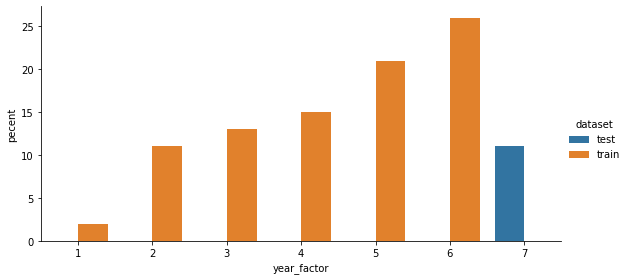

In [91]:
sns.catplot(x= 'year_factor', y='pecent',
           data= plot,
           hue='dataset',
           kind='bar',
           height=4,
           aspect=2)

`train` set contains data points of 7 states, however, `test` doesn't have any data point from `State_6` and `State_10`

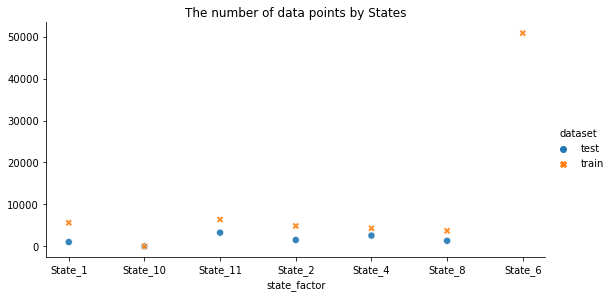

In [102]:
ax = sns.relplot(x='state_factor', 
                 y='building_id', 
                 data=df_all.groupby(['dataset','state_factor']).agg({'building_id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=2,
                 height=4,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by States",
    ylabel=None)

Text(0.5, 0, '')

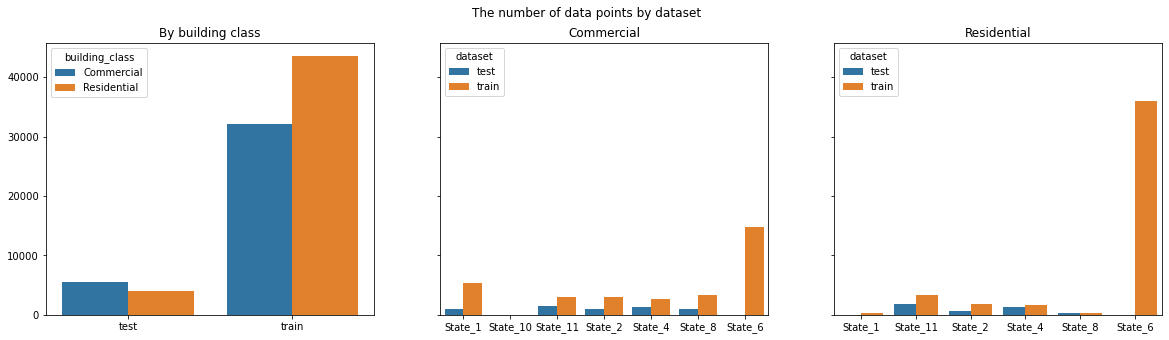

In [109]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
fig.suptitle("The number of data points by dataset")

sns.barplot(x='dataset',
            y='building_id',
            data=df_all.groupby(['dataset','building_class']).agg({'building_id':'count'}).reset_index(),
            hue='building_class',
            ax=ax[0],
            ci=False)

for e, s in enumerate(df_all['building_class'].unique(),1):
    sns.barplot(x='state_factor',
                y='building_id',
                data=df_all[df_all['building_class']==s].groupby(['dataset','state_factor']).agg({'building_id':'count'}).reset_index(),
                hue='dataset',
                ax=ax[e],
                ci=False)
    ax[e].set_title(s)
    ax[e].set_ylabel("")
    ax[e].set_xlabel("")

ax[0].set_title("By building class")
ax[0].set_ylabel("")
ax[0].set_xlabel("")

In [115]:
df_all.loc[(df_all['state_factor'] == 'State_10') & ((df_all['dataset'] == 'train'))].shape

(15, 65)

In [116]:
df_all.loc[(df_all['state_factor'] == 'State_10') & ((df_all['dataset'] == 'test'))].shape

(4, 65)

In [31]:
df_all['facility_type'].nunique()

60

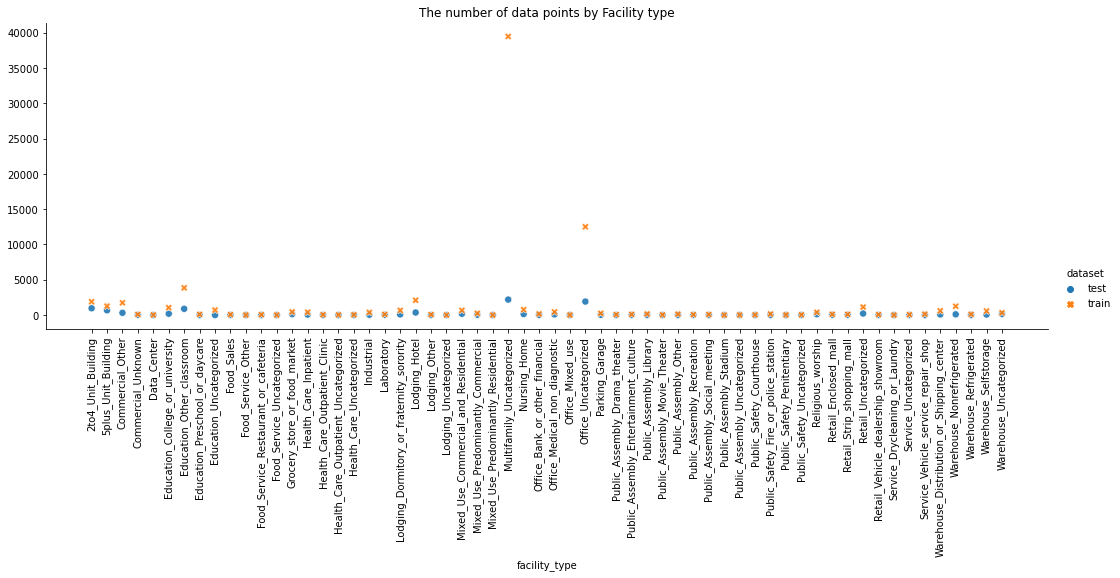

In [30]:
ax = sns.relplot(x='facility_type', 
                 y='building_id', 
                 data=df_all.groupby(['dataset','facility_type']).agg({'building_id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=3,
                 height=5,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by Facility type",
    ylabel=None)

ax.set_xticklabels(rotation=90) 
None

In [33]:
df_all.isna().sum() [df_all.isna().sum() != 0]

year_built                    1929
energy_star_rating           28963
direction_max_wind_speed     49657
direction_peak_wind_speed    50386
max_wind_speed               49657
days_with_fog                54913
site_eui                      9705
dtype: int64

Observation - The oldest building was built in 1600 and the latest in 2016. There were some 0 and null values.

In [44]:
df_all['year_built'].value_counts().index.sort_values()

Float64Index([   0.0, 1600.0, 1649.0, 1732.0, 1756.0, 1789.0, 1799.0, 1800.0,
              1811.0, 1815.0,
              ...
              2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0,
              2015.0, 2016.0],
             dtype='float64', length=183)

In [50]:
## tempararily replace nan and 0's 
## something which is not there in 'year_built' 
## I choose to replace with 2100

temp = df_all[['year_built']].fillna(2100).replace({0:2100}).astype('category').value_counts().reset_index().rename({0:'count'},axis=1)\
            .sort_values('year_built')

temp

,year_built,count
154,1600.0,6
162,1649.0,4
182,1732.0,1
158,1756.0,5
165,1789.0,4
...,...,...
72,2013.0,531
92,2014.0,403
108,2015.0,209
118,2016.0,87


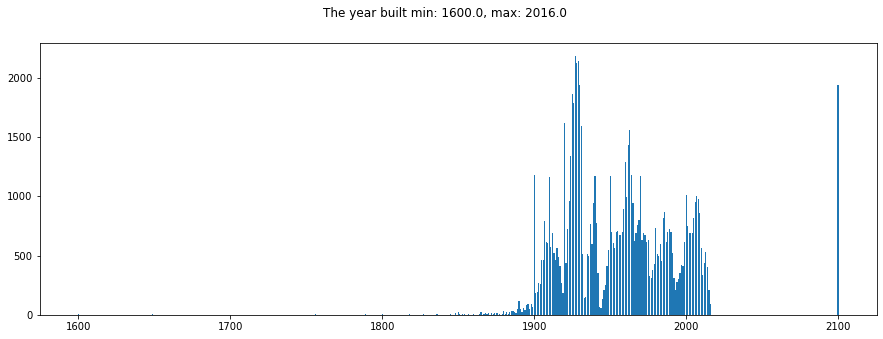

In [51]:
fig, ax = plt.subplots(figsize=(15,5))

ax=plt.bar(temp['year_built'],
           temp['count']
          )

fig.suptitle(f"The year built min: {min(temp['year_built'])}, max: {max(df_all['year_built'])}");

In [56]:
df_all['energy_star_rating'].value_counts()

100.0    2198
1.0      1097
89.0      927
84.0      924
85.0      912
         ... 
16.0      284
11.0      284
12.0      282
10.0      272
0.0         1
Name: energy_star_rating, Length: 101, dtype: int64

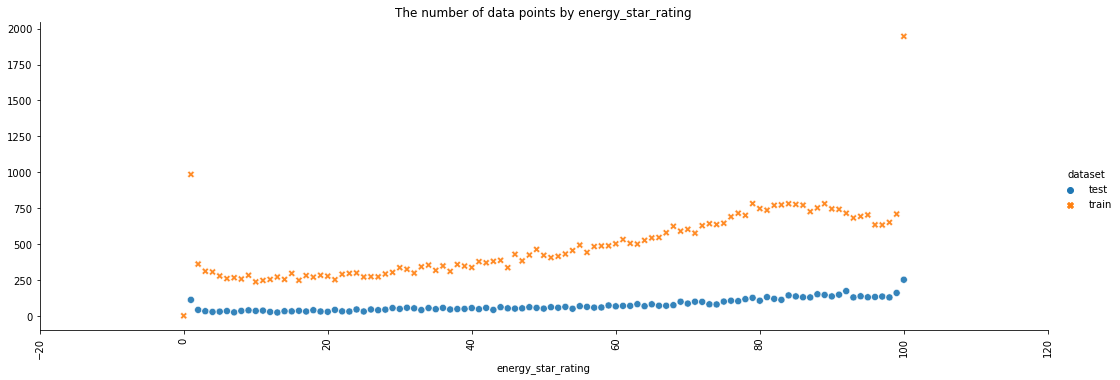

In [59]:
ax = sns.relplot(x='energy_star_rating', 
                 y='building_id', 
                 data=df_all.groupby(['dataset','energy_star_rating']).agg({'building_id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=3,
                 height=5,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by energy_star_rating",
    ylabel=None)

ax.set_xticklabels(rotation=90) 
None

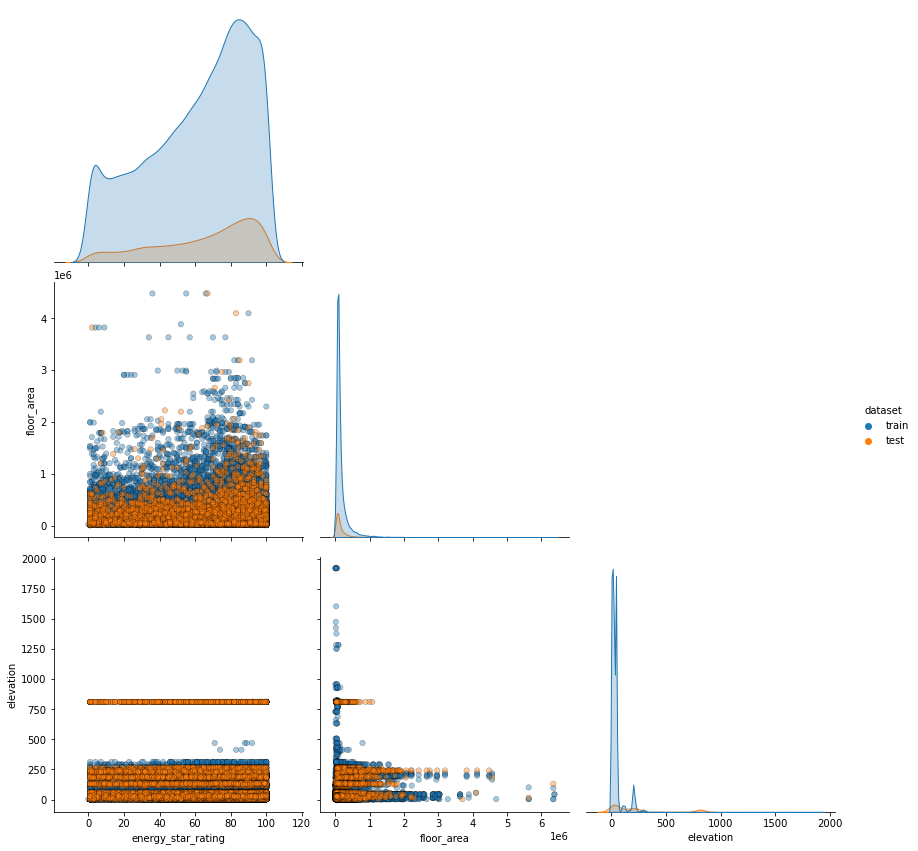

In [62]:
## Lets pair 'energy_star_rating' with 'floor_area' and'elevation'
sns.pairplot(df_all,
            vars=['energy_star_rating', 'floor_area','elevation'],
            hue='dataset',
            height=4,
            plot_kws = {'alpha': 0.4, 's': 30, 'edgecolor': 'k'},
            corner=True
           )

In [63]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85462 entries, 0 to 85461
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year_factor                85462 non-null  int64  
 1   state_factor               85462 non-null  object 
 2   building_class             85462 non-null  object 
 3   facility_type              85462 non-null  object 
 4   floor_area                 85462 non-null  float64
 5   year_built                 83533 non-null  float64
 6   energy_star_rating         56499 non-null  float64
 7   elevation                  85462 non-null  float64
 8   january_min_temp           85462 non-null  int64  
 9   january_avg_temp           85462 non-null  float64
 10  january_max_temp           85462 non-null  int64  
 11  february_min_temp          85462 non-null  int64  
 12  february_avg_temp          85462 non-null  float64
 13  february_max_temp          85462 non-null  int

observation

According to the average temperature (avg_temp), 

if we list states from warmest to coldest on state_factor and building_class

The range of temperatures of State 1, State 4, State 6 and State 11 in `state_factor` are higher compared to the other states.

The range of temperatures of Commercial in `building_class` is higher compared to the Residential.

In [64]:
#Categorical features - `State_Factor`, `building_class`, `facility_type`

print(df_all.state_factor.nunique())
print(df_all.building_class.nunique())
print(df_all.facility_type.nunique())

7
2
60


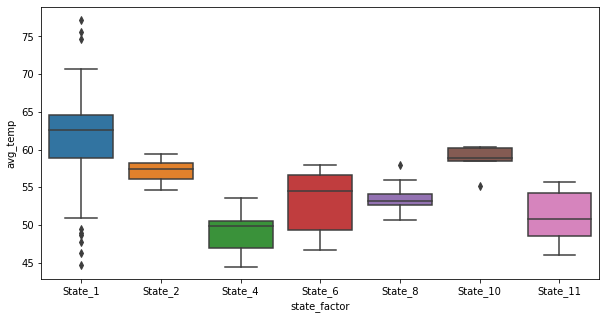

In [66]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_all[['avg_temp','state_factor']].drop_duplicates(), y='avg_temp', x='state_factor');

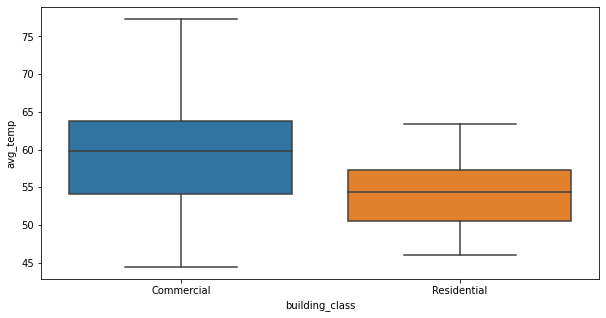

In [67]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_all[['avg_temp','building_class']].drop_duplicates(), y='avg_temp', x='building_class');

Every months min_temp, avg_temp, max_temp is observed 

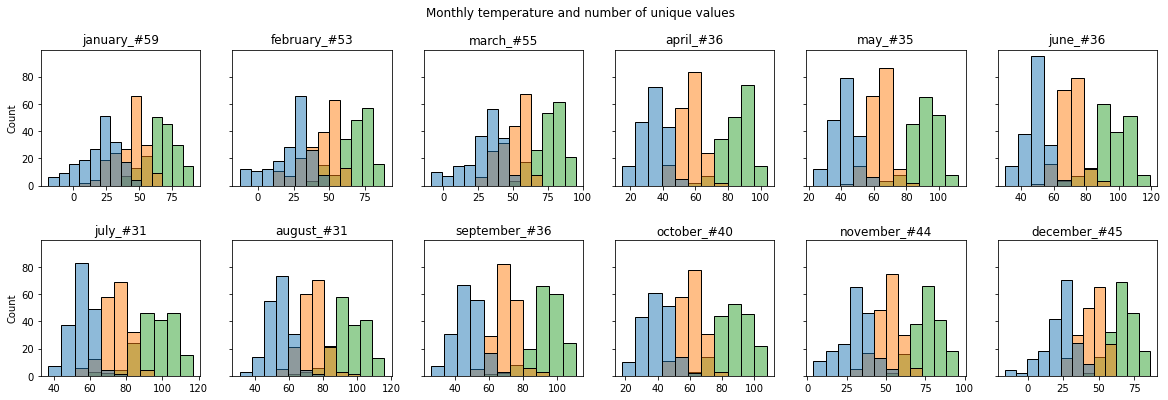

In [81]:
cols = [['january_min_temp', 'january_avg_temp', 'january_max_temp'],
         ['february_min_temp', 'february_avg_temp', 'february_max_temp'],
         ['march_min_temp', 'march_avg_temp', 'march_max_temp'], 
         ['april_min_temp','april_avg_temp', 'april_max_temp'], 
         ['may_min_temp', 'may_avg_temp','may_max_temp'], 
         ['june_min_temp', 'june_avg_temp', 'june_max_temp'],
         ['july_min_temp', 'july_avg_temp', 'july_max_temp'], 
         ['august_min_temp','august_avg_temp', 'august_max_temp'], 
         ['september_min_temp','september_avg_temp', 'september_max_temp'], 
         ['october_min_temp','october_avg_temp', 'october_max_temp'], 
         ['november_min_temp','november_avg_temp', 'november_max_temp'], 
         ['december_min_temp','december_avg_temp', 'december_max_temp']]

fig, ax = plt.subplots(2, 6, figsize=(20,6), sharey=True)
fig.suptitle("Monthly temperature and number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[0,e], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[1,e-6], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
        
plt.subplots_adjust(hspace=0.4)

looking at other weather related numerical columns unique values at once.

Ex - looking at df_all.cooling_degree_days.nunique() - 170
df_all.heating_degree_days.nunique() - 178 

similarly histogram of the feature sns.histplot(df_all[`cooling_degree_days`].drop_duplicates(), legend=False)

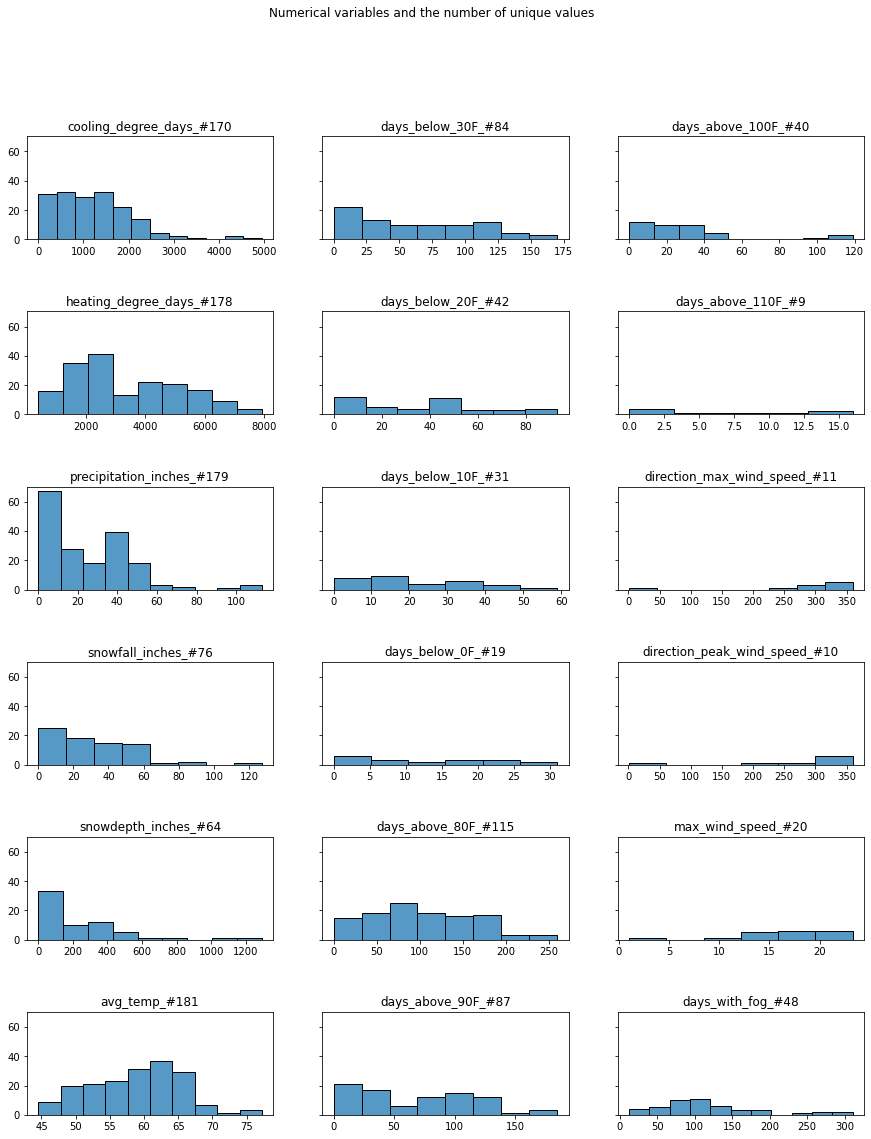

In [82]:
cols=['cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']

fig, ax = plt.subplots(6,3, figsize=(15,18), sharey=True)
fig.suptitle("Numerical variables and the number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e,0], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    elif (e>=6) & (e<=11):
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-6,1], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-12,2], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
        
plt.subplots_adjust(hspace=0.7)

## Analysing Target variable
finding correlation b/w target feature with categorical and numberical features

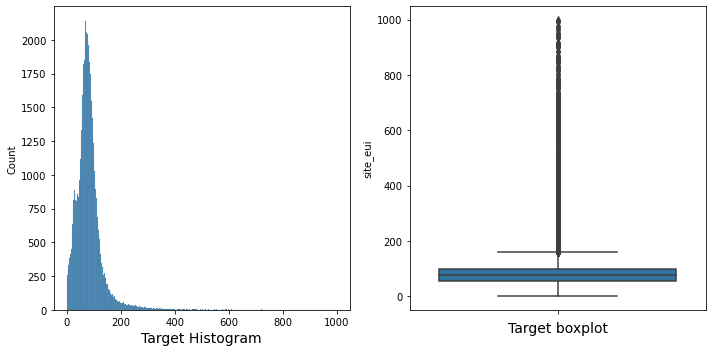

In [110]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
cp = sns.histplot(x=df_all['site_eui'])
ax1.set_xlabel('Target Histogram', fontsize=14)


ax2 = plt.subplot(1,2,2)
sns.boxplot(y=df_all['site_eui'])
ax2.set_xlabel('Target boxplot', fontsize=14)
plt.tight_layout()

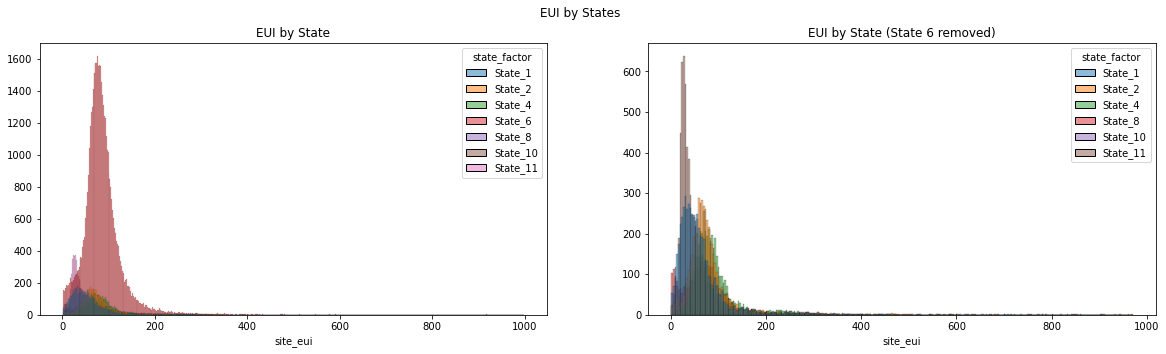

In [121]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle("EUI by States")

sns.histplot(df_all, x='site_eui',hue='state_factor', ax=ax[0])\
.set(title='EUI by State', ylabel=None)

sns.histplot(df_all[df_all['state_factor']!='State_6'], x='site_eui', hue='state_factor', ax=ax[1])\
.set(title='EUI by State (State 6 removed)', ylabel=None);

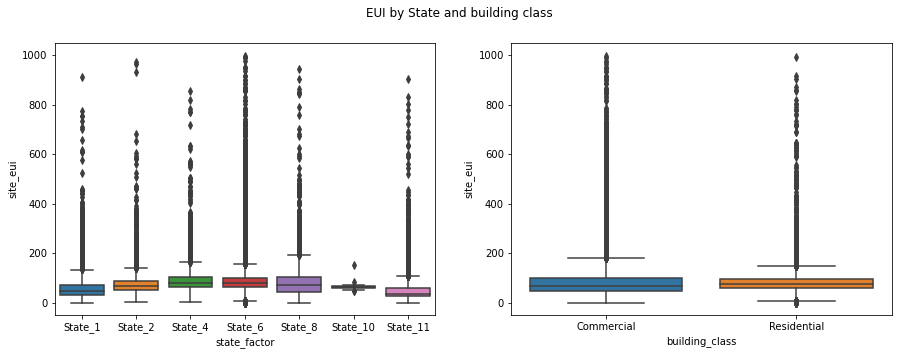

In [123]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("EUI by State and building class")

sns.boxplot(data=df_all, y='site_eui', x='state_factor', ax=ax[0])
sns.boxplot(data=df_all, y='site_eui', x='building_class', ax=ax[1])

Labs and Data Centers have higher EUI compared to the other types of buildings. Grocery stores, Health Care Inpatient, Health Care Uncategorized, Health Care Outpatient, and Food service, restaurants have higher range of EUI. It could be the essential services must operate for longer hours, therefore, have higher EUI.

[Text(0, 0, 'Grocery_store_or_food_market'),
 Text(1, 0, 'Warehouse_Distribution_or_Shipping_center'),
 Text(2, 0, 'Retail_Enclosed_mall'),
 Text(3, 0, 'Education_Other_classroom'),
 Text(4, 0, 'Warehouse_Nonrefrigerated'),
 Text(5, 0, 'Warehouse_Selfstorage'),
 Text(6, 0, 'Office_Uncategorized'),
 Text(7, 0, 'Data_Center'),
 Text(8, 0, 'Commercial_Other'),
 Text(9, 0, 'Mixed_Use_Predominantly_Commercial'),
 Text(10, 0, 'Office_Medical_non_diagnostic'),
 Text(11, 0, 'Education_College_or_university'),
 Text(12, 0, 'Industrial'),
 Text(13, 0, 'Laboratory'),
 Text(14, 0, 'Public_Assembly_Entertainment_culture'),
 Text(15, 0, 'Retail_Vehicle_dealership_showroom'),
 Text(16, 0, 'Retail_Uncategorized'),
 Text(17, 0, 'Lodging_Hotel'),
 Text(18, 0, 'Retail_Strip_shopping_mall'),
 Text(19, 0, 'Education_Uncategorized'),
 Text(20, 0, 'Health_Care_Inpatient'),
 Text(21, 0, 'Public_Assembly_Drama_theater'),
 Text(22, 0, 'Public_Assembly_Social_meeting'),
 Text(23, 0, 'Religious_worship'),
 Text(2

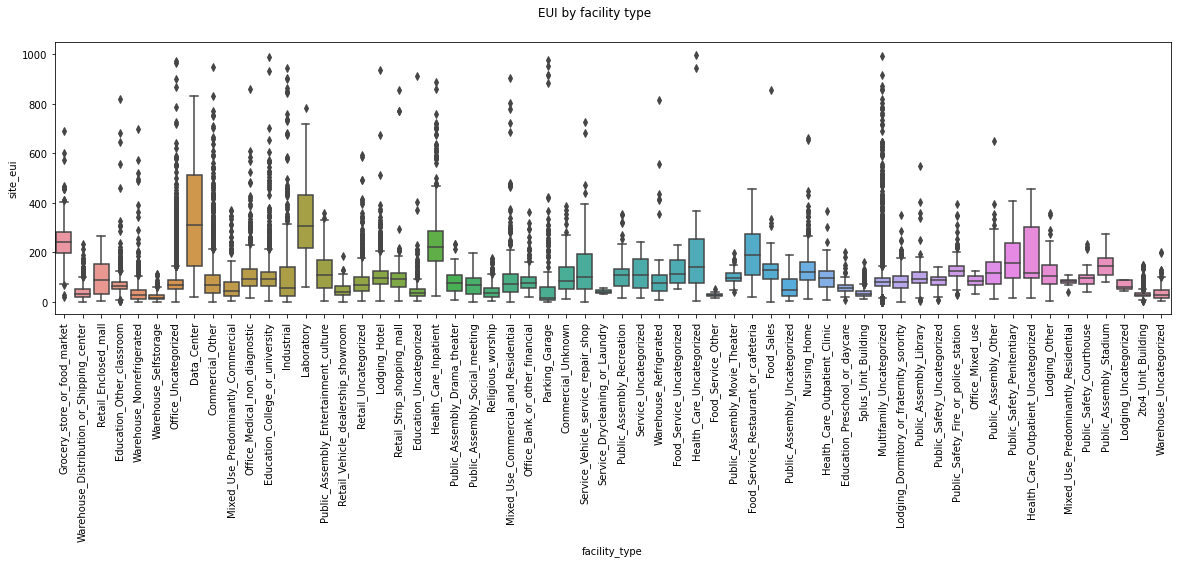

In [124]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle("EUI by facility type")
ax=sns.boxplot(data=df_all, y='site_eui', x='facility_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

`floor_area` could have positive relationship with `EUI`. The younger buildings tend to have higher `EUI` which could be because building height and size have increased over the years. It looks like the Higher the `energy_star_rating` is, the lower the `EUI` becomes.

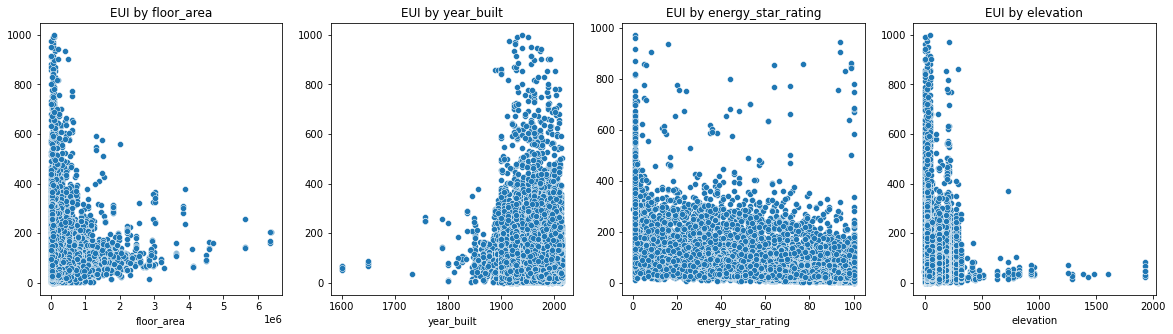

In [125]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for e, col in enumerate(['floor_area', 'year_built', 'energy_star_rating', 'elevation']):
    if col =='year_built':
        sns.scatterplot(data=df_all[(df_all['year_built']!=0) & (df_all['year_built'].notna())], 
                        x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None)
    else:
        sns.scatterplot(data=df_all, x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None);

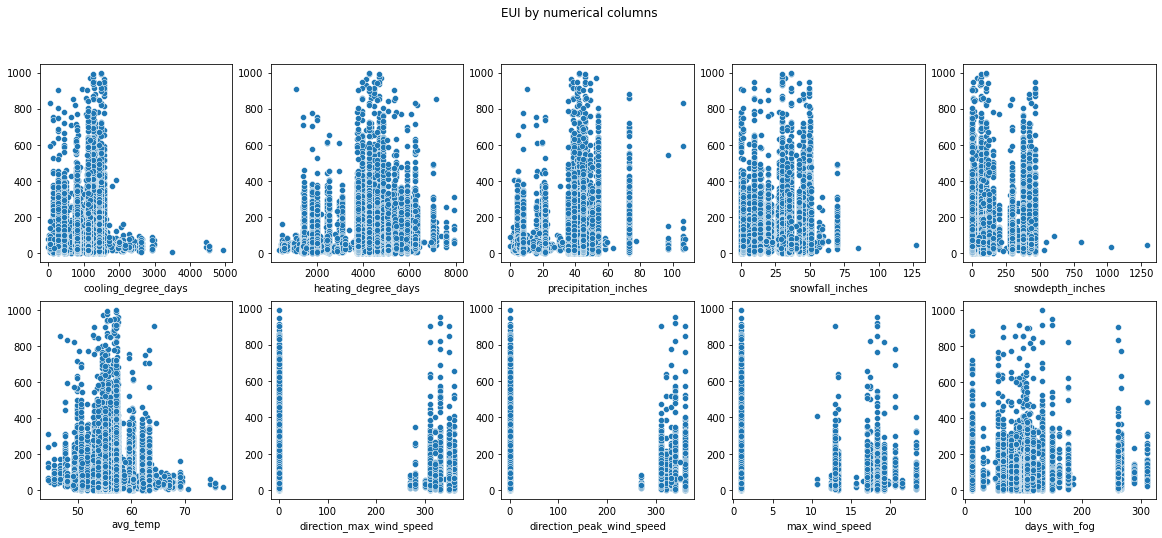

In [128]:
cols=[['cooling_degree_days','heating_degree_days', 'precipitation_inches', 
      'snowfall_inches','snowdepth_inches'], 
      ['avg_temp', 
      'direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 
      'days_with_fog']]

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('EUI by numerical columns')

for e1, l in enumerate(cols):
    for e2, col in enumerate(l):
        sns.scatterplot(data=df_all, 
                        x=col, y='site_eui', ax=ax[e1, e2]).set(ylabel=None)

# Preprocessing

we will suppose that if two buildings have the same values for these features;
they are the same building, in other words groupby_cols = (building_id)

Removing duplicates by clubbing similar building data

In [130]:
groupby_cols = ['state_factor','building_class','facility_type','floor_area','year_built']
df_all = df_all.sort_values(by=groupby_cols+['year_factor']).reset_index(drop=True)

Null imputation for categorical values: KNN Imputing

In [132]:
df_all.select_dtypes(include=['object']).columns

Index(['state_factor', 'building_class', 'facility_type', 'dataset'], dtype='object')

In [134]:
cats = ['state_factor', 'facility_type', 'building_class']
for col in cats:
    dummies = pd.get_dummies(df_all[col], dummy_na=False)
    for ohe_col in dummies:
        df_all[f'ohe_{col}_{ohe_col}'] = dummies[ohe_col]

In [137]:
knn_imputing = False
target='site_eui'

if knn_imputing:
    imputer = KNNImputer(n_neighbors=7)
    tmp = df_all[['state_factor', 'building_class', 'facility_type', 'dataset', target]]
    df = df_all.drop(tmp.columns, axis=1)
    df1 = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
    
    tmp.to_csv('imputer_tmp.csv', index=False)
    df1.to_csv('imputer_df1.csv', index=False)
    joblib.dump(imputer, 'knn_imputer.pkl')

else:
    df1 = pd.read_csv('imputer_df1.csv')
    tmp = df_all[['state_factor', 'building_class', 'facility_type', 'dataset', target]]
    df_all = df_all.drop(tmp.columns, axis=1)
    
    for col in tmp.columns:
        df_all[col]=tmp[col]
    for col in df1.columns:
        df_all[col] = df1[col]

In [143]:
from category_encoders import TargetEncoder

cats = ['state_factor', 'building_class', 'facility_type']
for col in cats:
    encoder = TargetEncoder()
    df_all[f'te_{col}'] = encoder.fit_transform(df_all[col], df_all[target])

/var/folders/1c/nf1fxz_x0nzg_hvw8mdntmgh0000gp/T/ipykernel_1746/2087603208.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[f'te_{col}'] = encoder.fit_transform(df_all[col], df_all[target])


# Feature Engineering

### Weather based features

we will extract new weather statistics from the building location weather features

In [149]:
# extract new weather statistics from the building location weather features
temp = [col for col in df_all.columns if 'temp' in col]

df_all['min_temp'] = df_all[temp].min(axis=1)
df_all['max_temp'] = df_all[temp].max(axis=1)
df_all['avg_temp'] = df_all[temp].mean(axis=1)
df_all['std_temp'] = df_all[temp].std(axis=1)
df_all['skew_temp'] = df_all[temp].skew(axis=1)


# by seasons
temp = pd.Series([col for col in df_all.columns if 'temp' in col])
winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values


### winter
df_all['min_winter_temp'] = df_all[winter_temp].min(axis=1)
df_all['max_winter_temp'] = df_all[winter_temp].max(axis=1)
df_all['avg_winter_temp'] = df_all[winter_temp].mean(axis=1)
df_all['std_winter_temp'] = df_all[winter_temp].std(axis=1)
df_all['skew_winter_temp'] = df_all[winter_temp].skew(axis=1)


### spring
df_all['min_spring_temp'] = df_all[spring_temp].min(axis=1)
df_all['max_spring_temp'] = df_all[spring_temp].max(axis=1)
df_all['avg_spring_temp'] = df_all[spring_temp].mean(axis=1)
df_all['std_spring_temp'] = df_all[spring_temp].std(axis=1)
df_all['skew_spring_temp'] = df_all[spring_temp].skew(axis=1)


### summer
df_all['min_summer_temp'] = df_all[summer_temp].min(axis=1)
df_all['max_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['avg_summer_temp'] = df_all[summer_temp].mean(axis=1)
df_all['std_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['skew_summer_temp'] = df_all[summer_temp].max(axis=1)


## autumn
df_all['min_autumn_temp'] = df_all[autumn_temp].min(axis=1)
df_all['max_autumn_temp'] = df_all[autumn_temp].max(axis=1)
df_all['avg_autumn_temp'] = df_all[autumn_temp].mean(axis=1)
df_all['std_autumn_temp'] = df_all[autumn_temp].std(axis=1)
df_all['skew_autumn_temp'] = df_all[autumn_temp].skew(axis=1)

In [150]:
df_all['month_cooling_degree_days'] = df_all['cooling_degree_days']/12
df_all['month_heating_degree_days'] = df_all['heating_degree_days']/12

### Buildig based feature:

we will extract building statistics

In [151]:
# total area
df_all['building_area'] = df_all['floor_area'] * df_all['elevation']
# rating energy by floor
df_all['floor_energy_star_rating'] = df_all['energy_star_rating']/df_all['elevation']

### Checking target variable transformation

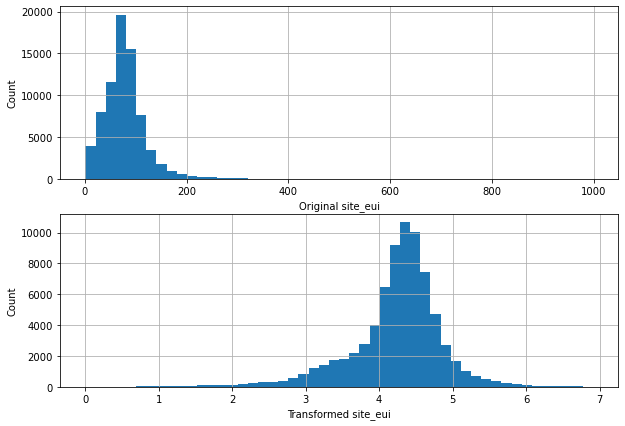

In [152]:
target = 'site_eui'
plt.figure(figsize=(10,7))
# plot the original variable vs sale price    
plt.subplot(2, 1, 1)
train[target].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Original ' + target)

# plot transformed variable vs sale price
plt.subplot(2, 1, 2)
np.log(train[target]).hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Transformed ' + target);

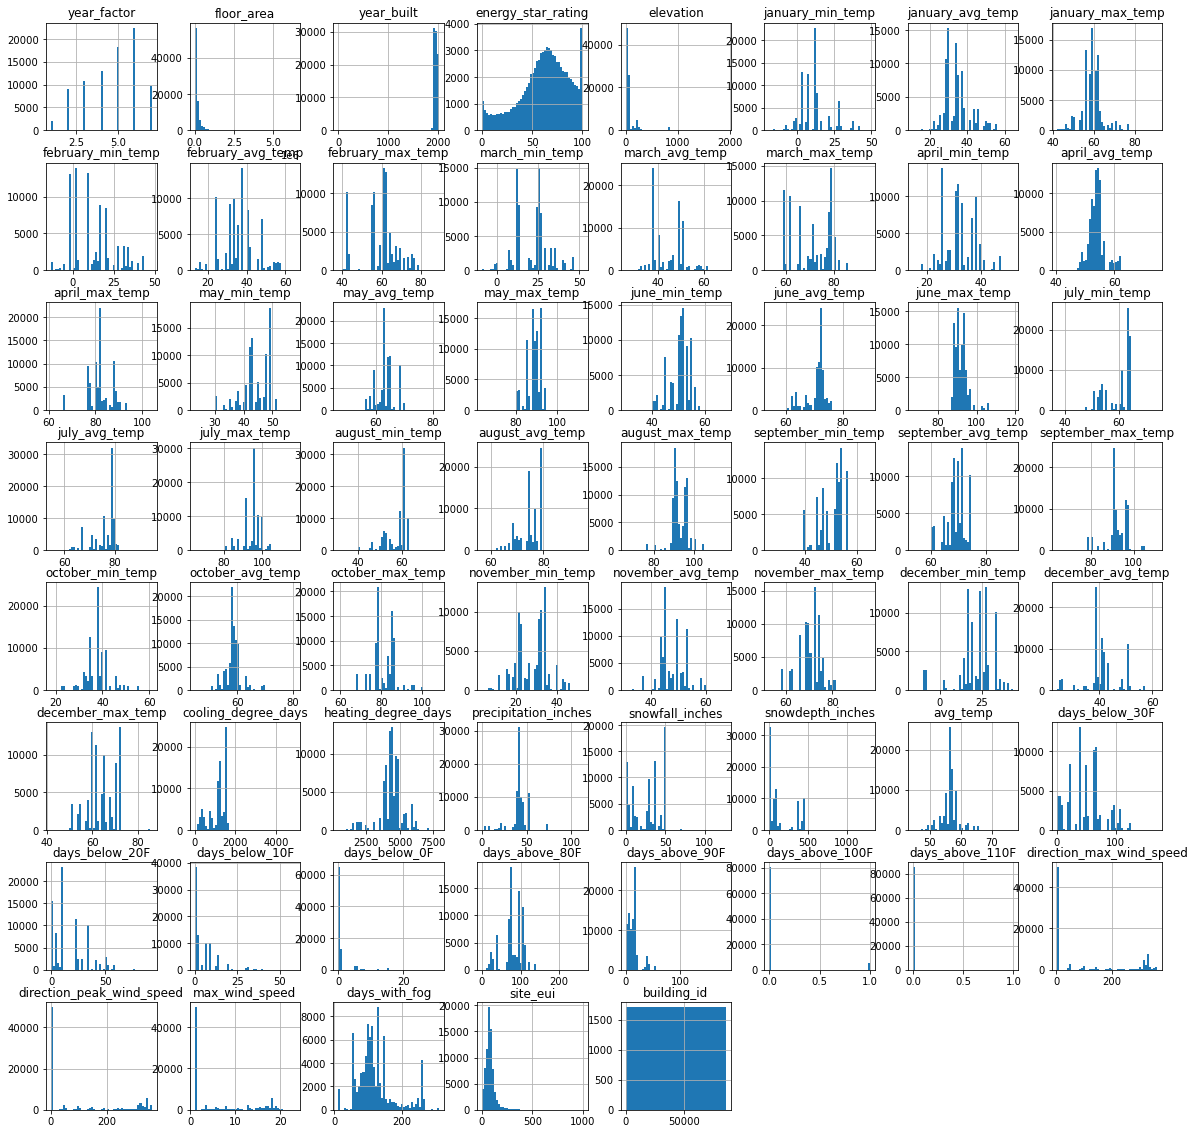

In [162]:
nums = train.loc[:, train.dtypes != 'object'].columns
nums = train.loc[:, train.dtypes != 'object'].columns
df_all[nums].hist(bins=50, figsize=(20,20))
plt.show()

In [163]:
df_all[nums].skew().sort_values(key=abs, ascending=False)[:10]

days_above_110F    37.390723
year_built        -11.716545
floor_area          6.701786
elevation           5.140444
site_eui            4.739972
days_below_0F       4.541444
days_above_100F     3.721213
days_above_90F      2.831602
days_below_10F      2.120237
june_max_temp       1.425201
dtype: float64

Binarize very skewed variables

In [158]:
skewed = ['days_above_110F', 'days_above_100F']

for var in skewed:
    
    # map the variable values into 0 and 1
    df_all[var] = np.where(df_all[var]==0, 0, 1)

### Saving feature dataset

In [165]:
saved = False
if saved:
    !pip install pickle5 --quiet
    import pickle5 as pickle
    data_path = 'feature_transformed_set.pkl'
    with open(data_path, "rb") as fh:
        df = pickle.load(fh)
else:
    df_all.to_pickle('feature_transformed_set.pkl')

In [161]:
df_all.shape

(85462, 175)

## Baseline

In [166]:
cats = ['state_factor', 'facility_type', 'building_class', 'days_above_100F', 'days_above_110F']

# typecasting numerical features
for col in df_all.drop(columns=cats + ['dataset', 'id', 'site_eui']).columns:
    df_all[col] = df_all[col].astype('float64')

In [167]:
df_all.drop(columns=cats)

,year_factor,floor_area,year_built,energy_star_rating,elevation,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,building_id,ohe_state_factor_State_1,ohe_state_factor_State_10,ohe_state_factor_State_11,ohe_state_factor_State_2,ohe_state_factor_State_4,ohe_state_factor_State_6,ohe_state_factor_State_8,ohe_facility_type_2to4_Unit_Building,ohe_facility_type_5plus_Unit_Building,ohe_facility_type_Commercial_Other,ohe_facility_type_Commercial_Unknown,ohe_facility_type_Data_Center,ohe_facility_type_Education_College_or_university,ohe_facility_type_Education_Other_classroom,ohe_facility_type_Education_Preschool_or_daycare,ohe_facility_type_Education_Uncategorized,ohe_facility_type_Food_Sales,ohe_facility_type_Food_Service_Other,ohe_facility_type_Food_Service_Restaurant_or_cafeteria,ohe_facility_type_Food_Service_Uncategorized,ohe_facility_type_Grocery_store_or_food_market,ohe_facility_type_Health_Care_Inpatient,ohe_facility_type_Health_Care_Outpatient_Clinic,ohe_facility_type_Health_Care_Outpatient_Uncategorized,ohe_facility_type_Health_Care_Uncategorized,ohe_facility_type_Industrial,ohe_facility_type_Laboratory,ohe_facility_type_Lodging_Dormitory_or_fraternity_sorority,ohe_facility_type_Lodging_Hotel,ohe_facility_type_Lodging_Other,ohe_facility_type_Lodging_Uncategorized,ohe_facility_type_Mixed_Use_Commercial_and_Residential,ohe_facility_type_Mixed_Use_Predominantly_Commercial,ohe_facility_type_Mixed_Use_Predominantly_Residential,ohe_facility_type_Multifamily_Uncategorized,ohe_facility_type_Nursing_Home,ohe_facility_type_Office_Bank_or_other_financial,ohe_facility_type_Office_Medical_non_diagnostic,ohe_facility_type_Office_Mixed_use,ohe_facility_type_Office_Uncategorized,ohe_facility_type_Parking_Garage,ohe_facility_type_Public_Assembly_Drama_theater,ohe_facility_type_Public_Assembly_Entertainment_culture,ohe_facility_type_Public_Assembly_Library,ohe_facility_type_Public_Assembly_Movie_Theater,ohe_facility_type_Public_Assembly_Other,ohe_facility_type_Public_Assembly_Recreation,ohe_facility_type_Public_Assembly_Social_meeting,ohe_facility_type_Public_Assembly_Stadium,ohe_facility_type_Public_Assembly_Uncategorized,ohe_facility_type_Public_Safety_Courthouse,ohe_facility_type_Public_Safety_Fire_or_police_station,ohe_facility_type_Public_Safety_Penitentiary,ohe_facility_type_Public_Safety_Uncategorized,ohe_facility_type_Religious_worship,ohe_facility_type_Retail_Enclosed_mall,ohe_facility_type_Retail_Strip_shopping_mall,ohe_facility_type_Retail_Uncategorized,ohe_facility_type_Retail_Vehicle_dealership_showroom,ohe_facility_type_Service_Drycleaning_or_Laundry,ohe_facility_type_Service_Uncategorized,ohe_facility_type_Service_Vehicle_service_repair_shop,ohe_facility_type_Warehouse_Distribution_or_Shipping_center,ohe_facility_type_Warehouse_Nonrefrigerated,ohe_facility_type_Warehouse_Refrigerated,ohe_facility_type_Warehouse_Selfstorage,ohe_facility_type_Warehouse_Uncategorized,ohe_building_class_Commercial,ohe_building_class_Residential,dataset,site_eui,Year_Factor,ELEVATION,id,ohe_State_Factor_State_1,ohe_State_Factor_State_10,ohe_State_Factor_State_11,ohe_State_Factor_State_2,ohe_State_Factor_State_4,ohe_State_Factor_State_6,ohe_State_Factor_State_8,

In [168]:
train = df_all[df_all['dataset']=='train']
test = df_all[df_all['dataset']=='test']

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

test_ids = test['id']
train_ids = train['id']

target = train['site_eui'] #y_train

train = train.drop(['id', 'dataset', 'site_eui'], axis=1) #X_train
test = test.drop(['id', 'dataset', 'site_eui'], axis=1) #X_test

## Label Encoding discrete features

In [169]:
# get discrete end categorical features colums indexes 
# needed later for the cat bosst model
cats_discrete_idx = np.where(train.dtypes != 'float64')[0]
# create the label
le = LabelEncoder()
for col_idx in cats_discrete_idx:
    train.iloc[:, col_idx] = le.fit_transform(train.iloc[:, col_idx].astype(str))
    test.iloc[:, col_idx] = le.transform(test.iloc[:, col_idx].astype(str))

In [170]:
print("Label Encoded Columns:")
for i in cats_discrete_idx:
    print(train.columns[i])

Label Encoded Columns:
days_above_100F
days_above_110F
state_factor
building_class
facility_type


In [172]:
y_test = pd.read_csv('y_test.csv')

X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (75757, 172)
Test: (9705, 172)
Samples:  (75757,)
Targets:  (9705,)


## Catboost

In [176]:

catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100
                        )

In [179]:
catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

y_pred = catb.predict(X_test)

0:	learn: 57.8334813	test: 61.2061174	best: 61.2061174 (0)	total: 455ms	remaining: 3m 46s
75:	learn: 44.3748122	test: 68.5062198	best: 61.2061174 (0)	total: 30.1s	remaining: 2m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 61.20611744
bestIteration = 0

Shrink model to first 1 iterations.


In [182]:
print(" *********Training data scores********\n")
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 *********Training data scores********

 RMSE: 61.206117463557305
 MAE: 40.31030037111586
 MSE: 3746.188814962775
 R2: -0.036095946751317554


## XGBoost

In [185]:
xgb = XGBRegressor(n_estimators=500, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(" *********Training data scores********\n")
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 *********Training data scores********

 RMSE: 94.11328542942984
 MAE: 68.15564350767524
 MSE: 8857.31049432133
 R2: -1.4496959324714203


## RandomForest

In [187]:
rf = RandomForestRegressor(random_state=1, criterion='mse', max_depth = 15, min_samples_split= 2)
rf.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(" *********Training data scores********\n")
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

/Users/Deepthi/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


 *********Training data scores********

 RMSE: 94.11328542942984
 MAE: 68.15564350767524
 MSE: 8857.31049432133
 R2: -1.4496959324714203


# Model Evaluation

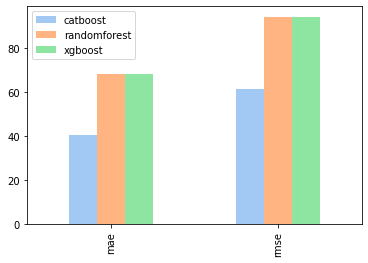

In [188]:
error_rec = {
    "catboost": {
        "mae": 40.31030037111586,
        "rmse": 61.206117463557305,
    },
    "randomforest": {
        "mae": 68.15564350767524,
        "rmse": 94.11328542942984,
    },
    "xgboost": {
        "mae": 68.15564350767524,
        "rmse": 94.11328542942984,
    },
}
pd.DataFrame(error_rec).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2], 
                 sns.color_palette("pastel")[3]]);

# Hyperparameter Tuning

### Using CrossValidation on CatBoost

In [192]:
# prepare the out of folds predictions 
train_oof = np.zeros((train.shape[0],))
test_preds = np.zeros(test.shape[0])

NUM_FOLDS = 5
kf = KFold(n_splits = NUM_FOLDS, shuffle=True, random_state=0)


for fold, (train_idx, test_idx) in tqdm.tqdm(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][test.columns], train.iloc[test_idx][test.columns]
    y_train, y_test = target[train_idx], target[test_idx]
    
    catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    # train model
    model = catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

    oof = model.predict(X_test)
    train_oof[test_idx] = oof
    test_preds += model.predict(test)/NUM_FOLDS      
    print(f"out-of-folds prdiction ====>>> fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))


0it [00:00, ?it/s]Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 58.0466432	test: 56.9890449	best: 56.9890449 (0)	total: 376ms	remaining: 3m 7s
75:	learn: 44.7797856	test: 44.5285792	best: 44.5285792 (75)	total: 26s	remaining: 2m 24s
150:	learn: 41.6542085	test: 42.4730563	best: 42.4730563 (150)	total: 52.1s	remaining: 2m
225:	learn: 40.2702717	test: 41.8756984	best: 41.8756984 (225)	total: 1m 19s	remaining: 1m 36s
300:	learn: 39.2591613	test: 41.5013529	best: 41.5013529 (300)	total: 1m 47s	remaining: 1m 10s
375:	learn: 38.5270157	test: 41.2953985	best: 41.2952411 (374)	total: 2m 14s	remaining: 44.2s
450:	learn: 37.8818763	test: 41.1227782	best: 41.1227782 (450)	total: 2m 42s	remaining: 17.6s
499:	learn: 37.4771462	test: 41.0271260	best: 41.0271163 (498)	total: 3m	remaining: 0us

bestTest = 41.02711629
bestIteration = 498

Shrink model to first 499 iterations.


1it [03:01, 181.73s/it]

out-of-folds prdiction ====>>> fold_0 RMSE 6.405241311587119


0:	learn: 57.9522751	test: 57.4178317	best: 57.4178317 (0)	total: 387ms	remaining: 3m 13s
75:	learn: 44.7211194	test: 45.1265670	best: 45.1265670 (75)	total: 28.4s	remaining: 2m 38s
150:	learn: 41.6975554	test: 43.0769592	best: 43.0769592 (150)	total: 54.3s	remaining: 2m 5s
225:	learn: 40.3614993	test: 42.3724399	best: 42.3724399 (225)	total: 1m 20s	remaining: 1m 37s
300:	learn: 39.3804343	test: 41.9573672	best: 41.9573672 (300)	total: 1m 47s	remaining: 1m 10s
375:	learn: 38.6249973	test: 41.7189560	best: 41.7189560 (375)	total: 2m 13s	remaining: 44.2s
450:	learn: 37.9873957	test: 41.5358875	best: 41.5358875 (450)	total: 2m 40s	remaining: 17.5s
499:	learn: 37.5916733	test: 41.4357709	best: 41.4344397 (497)	total: 2m 57s	remaining: 0us

bestTest = 41.43443974
bestIteration = 497

Shrink model to first 498 iterations.


2it [06:00, 179.89s/it]

out-of-folds prdiction ====>>> fold_1 RMSE 6.436958887244067


0:	learn: 57.6585377	test: 58.5593775	best: 58.5593775 (0)	total: 383ms	remaining: 3m 11s
75:	learn: 44.0961279	test: 47.1033193	best: 47.1033193 (75)	total: 27.1s	remaining: 2m 30s
150:	learn: 40.9202884	test: 45.3769314	best: 45.3769314 (150)	total: 54.9s	remaining: 2m 6s
225:	learn: 39.4806338	test: 44.8808673	best: 44.8808673 (225)	total: 1m 21s	remaining: 1m 38s
300:	learn: 38.5333221	test: 44.6443357	best: 44.6443357 (300)	total: 1m 47s	remaining: 1m 11s
375:	learn: 37.7612212	test: 44.4774674	best: 44.4774674 (375)	total: 2m 14s	remaining: 44.4s
450:	learn: 37.1147591	test: 44.3739529	best: 44.3739529 (450)	total: 2m 40s	remaining: 17.5s
499:	learn: 36.7543187	test: 44.3072338	best: 44.3072338 (499)	total: 2m 57s	remaining: 0us

bestTest = 44.30723376
bestIteration = 499



3it [08:59, 179.40s/it]

out-of-folds prdiction ====>>> fold_2 RMSE 6.656367917998247


0:	learn: 58.4447677	test: 55.3314554	best: 55.3314554 (0)	total: 381ms	remaining: 3m 10s
75:	learn: 44.8289884	test: 43.4344934	best: 43.4344934 (75)	total: 27.4s	remaining: 2m 32s
150:	learn: 41.6393603	test: 41.7665789	best: 41.7665789 (150)	total: 54.7s	remaining: 2m 6s
225:	learn: 40.1774455	test: 41.3299081	best: 41.3299081 (225)	total: 1m 22s	remaining: 1m 39s
300:	learn: 39.1856955	test: 41.1062284	best: 41.1062284 (300)	total: 1m 49s	remaining: 1m 12s
375:	learn: 38.5266124	test: 41.0327841	best: 41.0324595 (374)	total: 2m 16s	remaining: 44.9s
450:	learn: 37.8851431	test: 40.9207939	best: 40.9207736 (446)	total: 2m 42s	remaining: 17.7s
499:	learn: 37.4699177	test: 40.8425099	best: 40.8425099 (499)	total: 3m	remaining: 0us

bestTest = 40.84250993
bestIteration = 499



4it [12:00, 180.11s/it]

out-of-folds prdiction ====>>> fold_3 RMSE 6.390814497248987


0:	learn: 57.0713601	test: 60.8042957	best: 60.8042957 (0)	total: 371ms	remaining: 3m 5s
75:	learn: 43.9217088	test: 48.1246239	best: 48.1246239 (75)	total: 27.8s	remaining: 2m 34s
150:	learn: 41.0369780	test: 45.9182444	best: 45.9182444 (150)	total: 55.1s	remaining: 2m 7s
225:	learn: 39.6985676	test: 45.1923100	best: 45.1923100 (225)	total: 1m 21s	remaining: 1m 39s
300:	learn: 38.8743979	test: 44.8652461	best: 44.8652461 (300)	total: 1m 47s	remaining: 1m 11s
375:	learn: 38.1581500	test: 44.6748236	best: 44.6748236 (375)	total: 2m 13s	remaining: 44.1s
450:	learn: 37.5762395	test: 44.5415103	best: 44.5415103 (450)	total: 2m 37s	remaining: 17.2s
499:	learn: 37.2329016	test: 44.4681198	best: 44.4668038 (496)	total: 2m 54s	remaining: 0us

bestTest = 44.46680381
bestIteration = 496

Shrink model to first 497 iterations.


5it [14:55, 179.12s/it]

out-of-folds prdiction ====>>> fold_4 RMSE 6.668343400218372


### Using Optuna with Random Forest

In [193]:
# cross validating training data
kfolds = KFold(n_splits=3, shuffle=True, random_state=42)

# Objective function
def random_forest_objective(trial, data=X_train, target=y_train):
    # Dictionary to store best parameters
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "max_features": trial.suggest_float("max_features", 0.01, 0.95)
    }
     
    model = RandomForestRegressor(**param)
    
    # Setting random seed and kfolds for cross-validation
    kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, data, target, cv=kfolds, scoring="neg_root_mean_squared_error")
    return scores.mean()

In [194]:
def tuner(objective, n=5, direction='minimize'): 
    # Create Study object
    study = optuna.create_study(direction="minimize")

    # Optimize the study
    study.optimize(objective, n_trials=n)

    # Print the result
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}")
    print(f"Optimized parameters: {best_params}\n")
    print("<<<<<<<<<< Tuning complete... >>>>>>>>>>")
    
    # Return best parameters for the model
    return best_params, best_score

In [200]:
%%time
rf_param, rf_score = tuner(random_forest_objective,1)
rf_tuned_model = RandomForestRegressor(**rf_param)

[I 2023-03-04 16:08:10,712] A new study created in memory with name: no-name-a93a0800-d999-41fd-9bd9-dfaf84e305f6
[I 2023-03-04 16:35:53,100] Trial 0 finished with value: -42.75338277398511 and parameters: {'n_estimators': 394, 'max_depth': 11, 'min_samples_split': 2, 'max_features': 0.3165311024924208}. Best is trial 0 with value: -42.75338277398511.


Best score: -42.75338277398511
Optimized parameters: {'n_estimators': 394, 'max_depth': 11, 'min_samples_split': 2, 'max_features': 0.3165311024924208}

<<<<<<<<<< Tuning complete... >>>>>>>>>>
CPU times: user 27min 17s, sys: 9.92 s, total: 27min 27s
Wall time: 27min 42s


In [201]:
rf_tuned_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=11, max_features=0.3165311024924208,
                      n_estimators=394)

### Final Evaluation

/Users/Deepthi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'iteration')

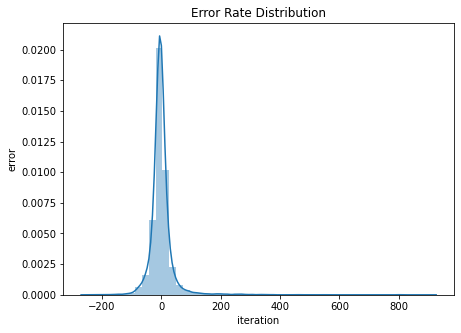

In [202]:
y_hat_tuned = catb.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

/Users/Deepthi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'iteration')

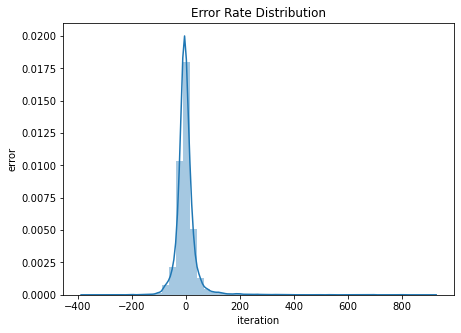

In [203]:
y_hat_tuned = rf_tuned_model.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

## Saving and loading model

In [208]:
with open('rf_tuned_final.joblib', 'wb') as f:
    joblib.dump(rf_tuned_model, f, compress=1)

with open('catb_best_final.joblib', 'wb') as f:
    joblib.dump(catb,f,compress=3)

In [209]:
## Load models here
load = False
if load:
    with open('models/rf_tuned_final.joblib', 'rb') as f:
        rf = joblib.load(f)

    with open('model/catb_best_final.joblib', 'rb') as f:
        catb = joblib.load(f)